In [1]:
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
import numpy as np
from os import scandir, walk, remove
import pandas as pd
from fastprogress import progress_bar
from fastai import *
from fastai.vision import *
from PIL import Image
from numbers import Integral

# Knockout on Image

In [14]:
class Knockout(nn.Module):
    def __init__(self, p: float = 0.5):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, but got {}".format(p))
        self.p = p

    def forward(self, x):
        if self.training:
            epsilon = 1e-8 # to prevent division by zero error
            binomial = torch.distributions.binomial.Binomial(probs=1-self.p)
            b, c, h, w = x.shape
            mask = binomial.sample((b, 1, h, w)).to(x.device)
            return x * mask * (1.0 /(1 - self.p + epsilon))
        return x

In [3]:
data_path = 'lbl_data_resized/'

In [4]:
trn_val = pd.read_csv("train_test_split_clean.csv")
trn_val_dict = {row.fname: row.is_val_set for _, row in trn_val.iterrows()}

In [5]:
def get_split(fname):
      return trn_val_dict[fname.name]

In [6]:
import re
pat = '^rice_'

def is_rice(fname):
    if re.search(pat,fname.stem): return True
    return False

In [7]:
src = (ImageList.from_folder(Path(data_path))
        .split_by_valid_func(get_split)
        .label_from_func(is_rice)
      )
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms,size=224)
        .databunch(bs=40)
        .normalize(imagenet_stats)
       )

In [8]:
def f1_score(y_pred:Tensor, y_true:Tensor,beta:float=1, eps:float=1e-9)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2

    y_pred = y_pred.argmax(dim=1).float()
    y_true = y_true.float()
    
    TP = (y_pred*y_true).sum()
    prec = TP/(y_pred.sum()+eps)
    rec = TP/(y_true.sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [15]:
model = nn.Sequential(Knockout(0.05), create_cnn_model(models.resnet34, nc=2))
learner = Learner(data, model, metrics=[accuracy, f1_score])

In [16]:
def _nts_split(m):
    groups = [[*list(m.children())[:1]]]
    groups += [[*list(m.children())[1:]]]
    return groups

In [17]:
learner.split(_nts_split);

In [18]:
learner.freeze()

In [19]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.685164,0.689939,0.551395,0.176295,00:48
1,0.683540,0.708393,0.546045,0.000000,00:47
2,0.678330,0.690720,0.546045,0.000000,00:47
3,0.669404,0.677615,0.556744,0.057492,00:48


In [20]:
learner.save('image-knockout-0.05')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 4.79E-05


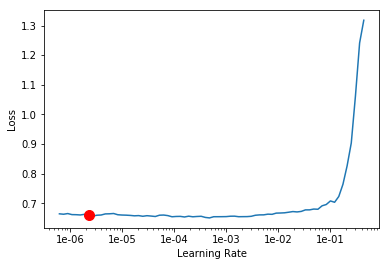

In [21]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [22]:
learner.fit_one_cycle(4, slice(1e-4, 1e-3))learner.fit_one_cycle(4, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.661300,0.686320,0.554834,0.141858,00:47
1,0.656441,0.675162,0.567062,0.160431,00:47
2,0.641097,0.638288,0.625525,0.422943,00:47
3,0.630838,0.627766,0.626290,0.464513,00:47


In [23]:
learner.save('image-knockout-0.05-1')

In [24]:
learner.load('image-knockout-0.05-1');

In [25]:
# Scores were improving. Train a bit more
learner.fit_one_cycle(4, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.638795,0.647651,0.622851,0.522228,00:47
1,0.640034,0.670955,0.583875,0.244298,00:47
2,0.633893,0.645971,0.592281,0.301015,00:47
3,0.625509,0.628184,0.623233,0.449556,00:47


In [26]:
learner.save('image-knockout-0.05-2')

In [27]:
learner.load('image-knockout-0.05-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.91E-07


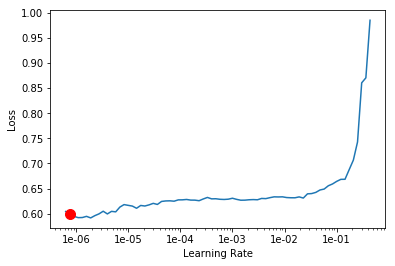

In [28]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [29]:
learner.load('image-knockout-0.05-2');
# Train using lower learning rates
learner.fit_one_cycle(4, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.618233,0.625967,0.625143,0.437362,00:47
1,0.614749,0.620943,0.631639,0.482121,00:47
2,0.610182,0.623444,0.627436,0.467528,00:47
3,0.617127,0.623806,0.623233,0.459258,00:47


In [30]:
learner.save('image-knockout-0.05-3')

In [31]:
learner.load('image-knockout-0.05-3');

In [32]:
# Increse knockout strength
learner.model[0].p = 0.6

In [34]:
learner.model[0].p

0.6

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.31E-08


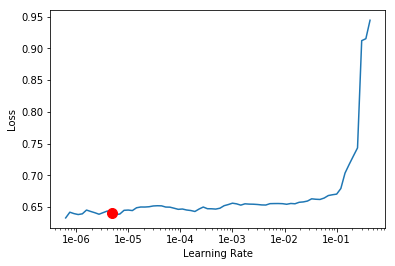

In [35]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [38]:
learner.load('image-knockout-0.05-3');
learner.model[0].p

0.6

In [39]:
learner.fit_one_cycle(5, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.657785,0.704422,0.518915,0.560130,00:47
1,0.635229,0.696178,0.546427,0.546194,00:47
2,0.625762,0.693911,0.559037,0.539116,00:47
3,0.638265,0.688990,0.565915,0.508767,00:47
4,0.625726,0.691770,0.555216,0.515824,00:47


In [40]:
learner.save('image-knockout-0.05-4')

In [41]:
learner.save('image-knockout-0.05-4');

In [42]:
learner.fit_one_cycle(10, slice(5e-7, 5e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.622256,0.688937,0.566297,0.512264,00:47
1,0.634089,0.693122,0.554452,0.528300,00:47
2,0.623785,0.691311,0.562858,0.512756,00:47
3,0.623719,0.690008,0.550631,0.488334,00:47
4,0.625921,0.689884,0.552159,0.496894,00:47
5,0.620315,0.688421,0.551395,0.480835,00:47
6,0.624409,0.690969,0.546427,0.491331,00:47
7,0.631498,0.688295,0.550631,0.482483,00:47
8,0.618660,0.689493,0.547191,0.487826,00:47
9,0.630323,0.688408,0.556362,0.473642,00:47


In [43]:
learner.save('image-knockout-0.06-4') #oops! saved the previous ones with the wrong name

In [44]:
learner.load('image-knockout-0.06-4');

In [45]:
# Increase the strength further
learner.model[0].p = 0.075

In [46]:
learner.model[0].p

0.075

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 5.75E-05


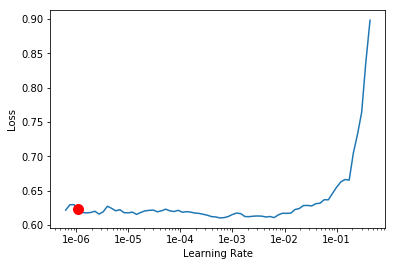

In [47]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [48]:
learner.load('image-knockout-0.06-4');
learner.unfreeze()

In [49]:
learner.fit_one_cycle(4, slice(1e-4, 8e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.633424,0.644236,0.599541,0.281636,00:47
1,0.627022,0.636013,0.608712,0.486597,00:48
2,0.615040,0.629463,0.631639,0.502543,00:47
3,0.615428,0.634697,0.628200,0.576221,00:47


In [50]:
learner.save('image-knockout-0.075-1')

In [51]:
learner.load('image-knockout-0.075-1');
learner.unfreeze()

In [52]:
# Keep training
learner.fit_one_cycle(5, slice(1e-4, 8e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.623521,0.626275,0.636225,0.537698,00:47
1,0.618029,0.629324,0.627436,0.607327,00:47
2,0.605447,0.633957,0.632786,0.573526,00:47
3,0.605470,0.651916,0.618647,0.599930,00:47
4,0.591503,0.649231,0.617501,0.600251,00:47


In [53]:
learner.save('image-knockout-0.075-2')

In [54]:
learner.load('image-knockout-0.075-2');
learner.unfreeze()

In [55]:
learner.fit_one_cycle(3, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.586465,0.655308,0.607948,0.578535,00:47
1,0.601581,0.657038,0.616737,0.613679,00:47
2,0.579254,0.649579,0.617883,0.600160,00:47


In [56]:
learner.save('image-knockout-0.075-3')

In [57]:
learner.load('image-knockout-0.075-3');
learner.unfreeze()

In [58]:
learner.fit_one_cycle(8, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.594029,0.657610,0.610241,0.605051,00:47
1,0.595189,0.665330,0.598013,0.593623,00:47
2,0.587125,0.654095,0.598395,0.576984,00:47
3,0.582803,0.644796,0.616737,0.604330,00:48
4,0.591925,0.656606,0.615208,0.619332,00:47
5,0.583139,0.654565,0.616355,0.617495,00:47
6,0.596621,0.652757,0.614826,0.608221,00:48
7,0.578322,0.650925,0.614062,0.611117,00:48


In [59]:
learner.save('image-knockout-0.075-4')

In [60]:
learner.load('image-knockout-0.075-4');

In [61]:
learner.model[0].p = 0.1

In [62]:
learner.model[0].p

0.1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


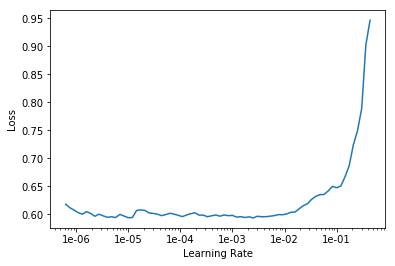

In [63]:
learner.lr_find()
learner.recorder.plot()

In [64]:
learner.load('image-knockout-0.075-4');
learner.unfreeze()

In [65]:
learner.fit_one_cycle(3, slice(2e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.592811,0.685455,0.605273,0.620506,00:48
1,0.594944,0.670805,0.606802,0.624457,00:48
2,0.591902,0.681614,0.602980,0.622978,00:48


In [66]:
learner.save('image-knockout-0.1-1')

In [67]:
learner.load('image-knockout-0.1-1');
learner.unfreeze()

In [68]:
learner.fit_one_cycle(3, slice(1e-56, 1e-5)) # 1e-56 is a typo but worked

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.573779,0.677657,0.606802,0.627388,00:49
1,0.578037,0.676572,0.606037,0.624090,00:49
2,0.585725,0.684834,0.597631,0.622393,00:49


In [69]:
learner.fit_one_cycle(7, slice(1e-56, 1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.580986,0.674464,0.608330,0.624289,00:48
1,0.578124,0.676646,0.598395,0.614350,00:49
2,0.572115,0.674032,0.615208,0.635731,00:48
3,0.588338,0.675252,0.607184,0.624884,00:49
4,0.574753,0.682584,0.606037,0.633119,00:49
5,0.591395,0.684656,0.603363,0.623548,00:49
6,0.575180,0.675354,0.609094,0.627351,00:49


In [70]:
learner.save('image-knockout-0.1-2')

In [71]:
learner.load('image-knockout-0.1-2');
learner.unfreeze()

In [72]:
learner.fit_one_cycle(7, slice(1e-7, 1e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.580997,0.684525,0.608712,0.631693,00:49
1,0.582098,0.692140,0.607184,0.636644,00:49
2,0.575273,0.682518,0.607184,0.635776,00:49
3,0.581731,0.679073,0.602598,0.620621,00:49
4,0.587707,0.682232,0.608712,0.630030,00:49
5,0.576168,0.676340,0.606802,0.625747,00:49
6,0.585476,0.679910,0.607948,0.626853,00:49


In [73]:
learner.save('image-knockout-0.1-3')

In [74]:
learner.model[0].p = 0.12

In [75]:
learner.model[0].p

0.12

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


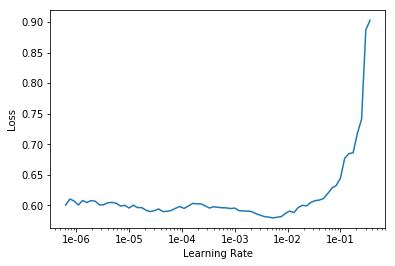

In [76]:
learner.lr_find()
learner.recorder.plot()

In [77]:
learner.load('image-knockout-0.1-3')
learner.unfreeze()

In [78]:
learner.fit_one_cycle(4, slice(2e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.605500,0.712721,0.589989,0.615742,00:48
1,0.603670,0.669389,0.601452,0.625006,00:48
2,0.597611,0.717772,0.555216,0.604238,00:48
3,0.579494,0.695530,0.598395,0.626867,00:48


In [79]:
learner.save('image-knockout-0.12-1')

In [80]:
learner.fit_one_cycle(6, slice(2e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.579550,0.691851,0.593428,0.618928,00:48
1,0.572571,0.701971,0.594574,0.632594,00:48
2,0.590593,0.698886,0.592281,0.629833,00:48
3,0.577039,0.724553,0.589606,0.637597,00:48
4,0.572508,0.704937,0.598013,0.637094,00:47
5,0.581367,0.701401,0.599541,0.633736,00:48


In [81]:
learner.save('image-knockout-0.12-2')

In [82]:
# Start decreasing the knockout strength now
learner.model[0].p = 0.9

In [83]:
learner.model[0].p

0.9

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


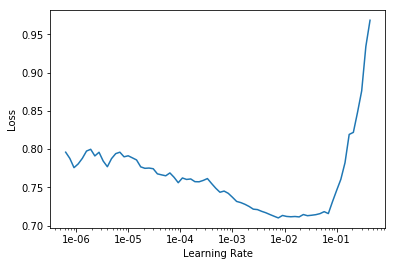

In [84]:
learner.lr_find()
learner.recorder.plot()

In [87]:
learner.load('image-knockout-0.12-2');
learner.unfreeze()

In [88]:
learner.fit_one_cycle(4, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.670830,0.720994,0.528850,0.578116,00:48
1,0.634511,0.720482,0.502484,0.602620,00:47
2,0.636438,0.748025,0.509744,0.616215,00:46
3,0.631454,0.738976,0.495224,0.612018,00:46


In [89]:
learner.save('image-knockout-0.9-1')

In [90]:
learner.fit_one_cycle(8, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.632844,0.744975,0.500955,0.613871,00:45
1,0.634183,0.755131,0.503630,0.612605,00:44
2,0.628601,0.740220,0.491020,0.615421,00:44
3,0.618548,0.736225,0.500191,0.614813,00:44
4,0.622610,0.730284,0.495606,0.612197,00:45
5,0.620557,0.733176,0.495988,0.618309,00:47
6,0.626935,0.733394,0.499809,0.614502,00:47
7,0.627154,0.735621,0.496752,0.617454,00:47


In [99]:
learner.load('image-knockout-0.12-2');
learner.unfreeze()

In [100]:
# Try halving the strength directly
learner.model[0].p = 0.6

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


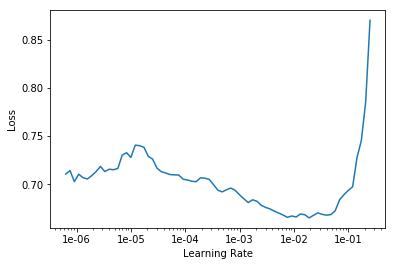

In [101]:
learner.lr_find()
learner.recorder.plot()

In [102]:
learner.fit_one_cycle(1, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.617871,0.810243,0.465036,0.500390,00:47


In [103]:
# Turn off knockout
learner.model[0].p = 0.0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


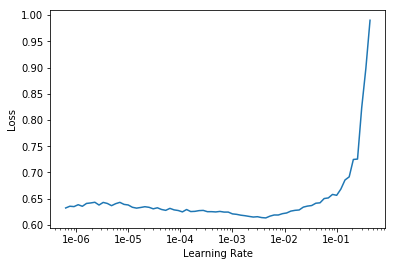

In [104]:
learner.lr_find()
learner.recorder.plot()

In [105]:
learner.fit_one_cycle(2, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.606507,0.615500,0.648070,0.490525,00:46
1,0.598790,0.606221,0.655331,0.503432,00:46


In [106]:
learner.save('image-knockout-0')

In [107]:
learner.fit_one_cycle(10, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.588382,0.604296,0.658005,0.511914,00:46
1,0.587389,0.603400,0.657241,0.508338,00:46
2,0.596116,0.604229,0.654566,0.505148,00:47
3,0.591097,0.604919,0.649981,0.498829,00:47
4,0.582430,0.596338,0.661826,0.540491,00:47
5,0.580017,0.599075,0.663737,0.533867,00:46
6,0.577105,0.599006,0.664883,0.546360,00:46
7,0.577837,0.594629,0.661826,0.540919,00:46
8,0.586297,0.597998,0.662973,0.532838,00:46
9,0.572369,0.600386,0.660298,0.524098,00:47


In [108]:
learner.save('image-knockout-0-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


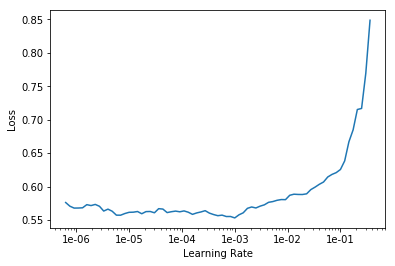

In [109]:
learner.lr_find()
learner.recorder.plot()

In [110]:
learner.load('image-knockout-0-1');
learner.unfreeze()

In [111]:
learner.fit_one_cycle(4, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.591170,0.600743,0.660680,0.527903,00:46
1,0.572947,0.596320,0.667176,0.549139,00:46
2,0.580382,0.593753,0.666794,0.556125,00:46
3,0.573498,0.594473,0.663737,0.540370,00:46


In [112]:
learner.save('image-knockout-0-2')

In [113]:
learner.fit_one_cycle(12, slice(1e-7, 1e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.572482,0.595878,0.666794,0.544936,00:46
1,0.577675,0.592480,0.664119,0.549533,00:46
2,0.579583,0.594228,0.664501,0.549195,00:46
3,0.584845,0.596018,0.661444,0.541851,00:46
4,0.578391,0.593755,0.664119,0.543165,00:46
5,0.574555,0.598713,0.664501,0.529958,00:46
6,0.577458,0.592111,0.666794,0.560429,00:46
7,0.572468,0.594025,0.666030,0.554717,00:46
8,0.575029,0.600622,0.665266,0.531931,00:46
9,0.571878,0.592934,0.666030,0.554563,00:46
